In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as plt 
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
import tensorflow as tf
import seaborn as sns


In [ ]:
def montagem_dataset(timestamp, features):
  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv('/content/drive/My Drive/TCC/dataset/EURUSD.csv', sep=';', header=0)
  # Escolha de features
  z = df.copy()
  df_train = z.iloc[ 0:int(len(z)*0.8),2:5]
  df_test   = z.iloc[ int(len(z)*0.8):,2:5]
  df_test_orig = z.iloc[ int(len(z)*0.8):,1:5]
  #Escala nas features
  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler()
  df_train = sc.fit_transform(df_train)
  #Formação do x_train
  x_train = []
  y_train = []
  length = len(df_train)
  for i in range(timestamp, length):
    x_train.append( df_train[i-timestamp:i,:])
    y_train.append( df_train[i,features-1])
  
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], timestamp, features))
  
  return x_train, y_train, df_test, df_test_orig, sc



In [ ]:
#Criação da rede neural
def treinamento_rede_neural(timestamp, features,  x_train, y_train, epochs):
  model = None
  model = Sequential()
  model.add(LSTM(units = 120, return_sequences = True, input_shape=( timestamp , features) ) ) 
  model.add(LSTM(units = 120, return_sequences = False)) 
  #model.add(Dropout(0.1))
  #model.add(Dense(units = 1)) 
  #model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  #model.add(LSTM(50, input_shape=(44725, x_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  model.fit(x_train, y_train, epochs = epochs)
  #model.save('drive/My Drive/TCC/modelo/LSTM')
  #import tensorflow as tf
  #model = tf.keras.models.load_model('drive/My Drive/TCC/modelo/LSTM')
  #df_test_close = df_test_close.reshape(-1, 1)
  #df_test = sc.fit_transform(df_test)
  return model

In [ ]:
def teste_rede(model, df_test,df_test_orig, sc, janela):
  #Escalando o dataset teste para comparação com as previsões
  from sklearn.preprocessing import MinMaxScaler
  sc1 = MinMaxScaler()
  df_test1 = df_test.copy()
  df_test1 = sc1.fit_transform(df_test1.iloc[:,features-1].values.reshape(-1,1))
  df_test = sc.fit_transform(df_test)

  #pegando maximos e minimos para testes com a previsao
  x_test =    []
  y_test =    []
  y_max  =    []
  y_min  =    [] 
  open_test = []
  length = len(df_test)
  for i in range(timestamp, length):
    x_test.append( df_test[i-timestamp:i,:])
    y_test.append( df_test[i,features-1])
    y_max.append( df_test_orig.iloc[i,2])
    y_min.append( df_test_orig.iloc[i,1])
    open_test.append( df_test_orig.iloc[i-1,3] )
  
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], timestamp, features))



  #Criando variavel Y_pred para receber as previsões
  y_pred = []
  y_pred = model.predict(x_test)

  #Invertendo a escala para valores reais
  predicted_price = sc1.inverse_transform(y_pred)
  y_test = sc1.inverse_transform(y_test.reshape(-1,1))

  #Calculos  para previsao
  previsao = pd.DataFrame(data=predicted_price , columns=['Previsão'])
  numero_real = pd.DataFrame(data=y_test , columns=['Fecahmaneto'])
  #y_max_pd = pd.DataFrame(data=y_max, columns=['Máxima'])
  preco_de_abertura = pd.DataFrame(data=open_test , columns=['Abertura'])
  maxima = pd.DataFrame(data=y_max , columns=['Máxima'])
  minima = pd.DataFrame(data=y_min , columns=['Mínima'])
  frames = [ preco_de_abertura, maxima, minima, numero_real, previsao]
  result = pd.concat(frames, axis=1, join='inner')
  #print(result[:24])


  #Graficos de previsao
  plt.plot(y_test[:janela], color='red', label='Preço Atual das Ações')
  plt.plot(result.index.values[:janela], result.iloc[:janela,4].values , '.')
  plt.fill_between(result.index.values[:janela], result.iloc[:janela,1].values, result.iloc[:janela,2], alpha=0.5)
  plt.title('Previsão de Preço de Ações')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.legend()
  plt.show()


  #####Calculo de acertos da previsao####################
  acumulador = 0
  lucro_prejuizo = []
  resumo_acumulado = []
  acertos = 0
  erros   = 0
  resumo  = []
  portcentagem = 0


  for i in range (0, janela):
      soma = 0
      if predicted_price[i] in pd.Interval(left=y_min[i], right=y_max[i]):
        soma = abs( np.round(predicted_price[i],5) - np.around(open_test[i], 5 ))
        soma = int(soma*100000)
        acertos = acertos + 1
      else:
        if y_test[i] > open_test[i]:
          if predicted_price[i] > open_test[i]:
            soma = abs( np.round(y_test[i], 5) - np.round(open_test[i], 5) )
            soma = int(soma*100000)
            acertos = acertos + 1
          else:
            soma = np.round(open_test[i], 5) - np.round(y_test[i], 5)
            soma = int(soma*100000)
            erros = erros + 1
        else:
          if predicted_price[i] < open_test[i]:
            soma = abs( np.round(y_test[i], 5) - np.round(open_test[i], 5))
            soma = int(soma*100000)
            acertos = acertos + 1
          else:
            soma = np.round(y_test[i], 5) - np.round(open_test[i], 5)
            soma = int(soma*100000)
            erros = erros + 1
      acumulador = acumulador + soma
      resumo_acumulado.append(acumulador)

  portcentagem = acertos*100/janela
  print("Acertos: ", acertos)
  print("Erros: ", erros)
  print("Pontos Ganhos: ", acumulador)
  print("%", portcentagem)
  print("Meses em teste estudados: ", int(len(predicted_price)/janela))
  # resumo = pd.DataFrame(data=lucro_prejuizo , columns=['Resumo'])
  resumo_acumulado = pd.DataFrame(data=resumo_acumulado , columns=['Resumo Acumulado '])
  #return acumulador
  
  previsao = pd.DataFrame(data=predicted_price , columns=['Previsão'])
  numero_real = pd.DataFrame(data=y_test , columns=['Fecahmaneto'])
  #y_max_pd = pd.DataFrame(data=y_max, columns=['Máxima'])
  preco_de_abertura = pd.DataFrame(data=open_test , columns=['Abertura'])
  maxima = pd.DataFrame(data=y_max , columns=['Máxima'])
  minima = pd.DataFrame(data=y_min , columns=['Mínima'])
  frames = [ preco_de_abertura, maxima, minima, numero_real, previsao,resumo_acumulado]
  result = pd.concat(frames, axis=1, join='inner')
  print(result)

  plt.plot(resumo_acumulado, color='blue', label='Preço Atual das Ações')
  plt.title('Resumo Acumulado')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.legend()
  plt.show()
  plt.title('Preço final')
  plt.xlabel('Tempo')
  plt.ylabel('Preço das Ações')
  plt.plot(y_test, color='red', label='Preço Atual das Ações')
  plt.show()
  return acumulador,portcentagem

In [ ]:
features = 3
timestamp = 2
epochs = 30
janela = 24
x_train = []
y_train = []
x_train = None
y_train = None
(x_train, y_train, df_test, df_test_orig, sc) = montagem_dataset(timestamp, features)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0131
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 5/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0055
Epoch 6/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0051
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 13/30
776/776 [====

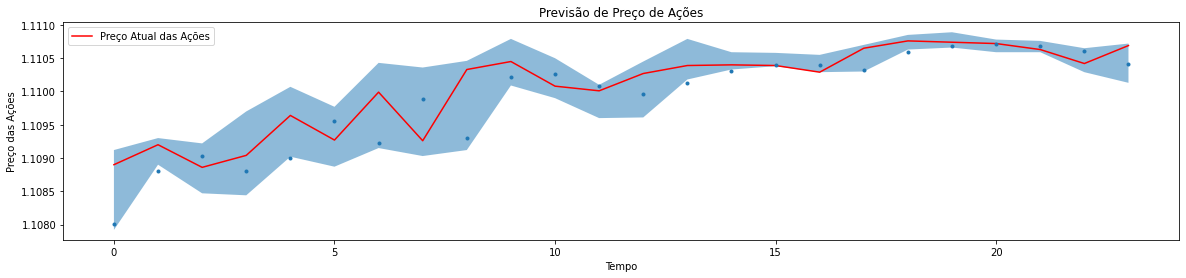

Acertos:  19
Erros:  5
Pontos Ganhos:  -5
% 79.16666666666667
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108012                  4
1    1.10890  1.10930  1.10890      1.10920  1.108802                -25
2    1.10920  1.10922  1.10847      1.10886  1.109028                 -9
3    1.10886  1.10970  1.10844      1.10904  1.108809                 -4
4    1.10904  1.11007  1.10902      1.10964  1.108997                -63
5    1.10964  1.10977  1.10887      1.10927  1.109555                -54
6    1.10927  1.11043  1.10915      1.10999  1.109228                -51
7    1.10999  1.11036  1.10903      1.10926  1.109882                -40
8    1.10926  1.11046  1.10912      1.11033  1.109298                -36
9    1.11033  1.11079  1.11009      1.11045  1.110211                -24
10   1.11045  1.11050  1.10990      1.11008  1.110262                 -5
11   1.11008  1.11010  1.10960 

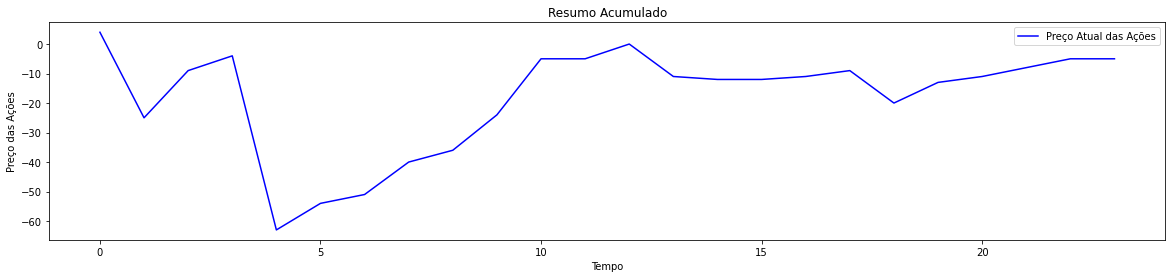

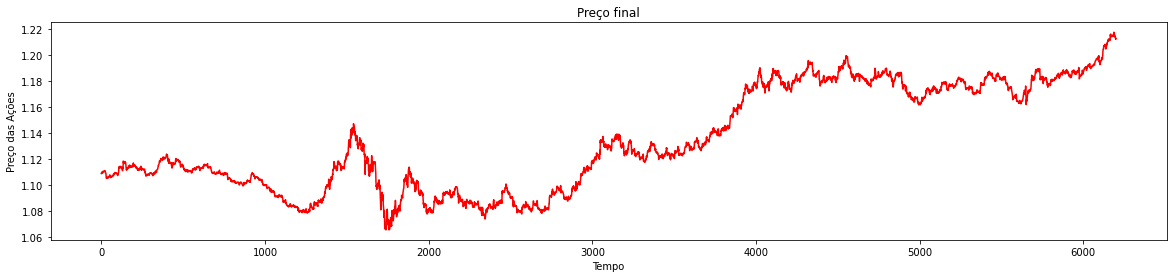

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0137
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0048
Epoch 12/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

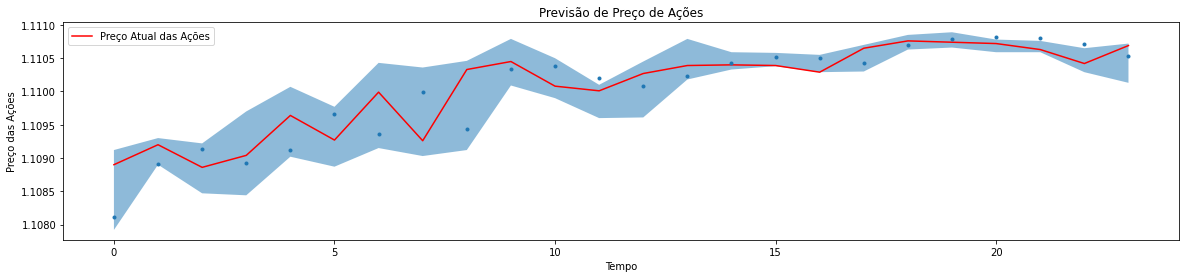

Acertos:  20
Erros:  4
Pontos Ganhos:  101
% 83.33333333333333
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108119                 14
1    1.10890  1.10930  1.10890      1.10920  1.108906                 15
2    1.10920  1.10922  1.10847      1.10886  1.109131                 21
3    1.10886  1.10970  1.10844      1.10904  1.108932                 27
4    1.10904  1.11007  1.10902      1.10964  1.109116                 34
5    1.10964  1.10977  1.10887      1.10927  1.109667                 37
6    1.10927  1.11043  1.10915      1.10999  1.109361                 46
7    1.10999  1.11036  1.10903      1.10926  1.109995                 47
8    1.10926  1.11046  1.10912      1.11033  1.109443                 65
9    1.11033  1.11079  1.11009      1.11045  1.110331                 65
10   1.11045  1.11050  1.10990      1.11008  1.110380                 71
11   1.11008  1.11010  1.10960

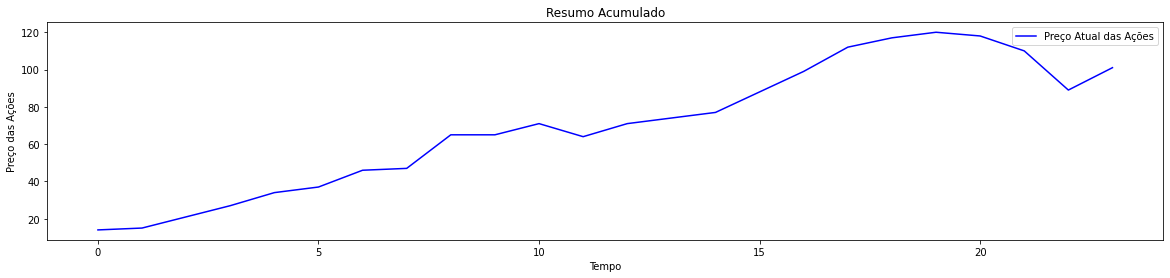

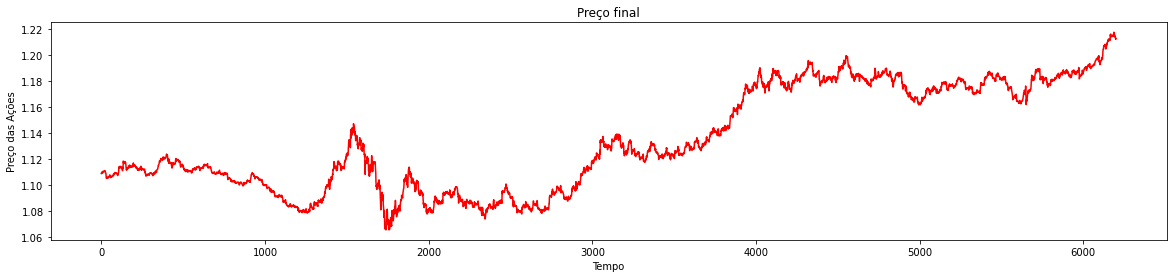

INFO:tensorflow:Assets written to: drive/My Drive/TCC/modelo/LSTM/assets
Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0128
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 12/30
776/776 [=============

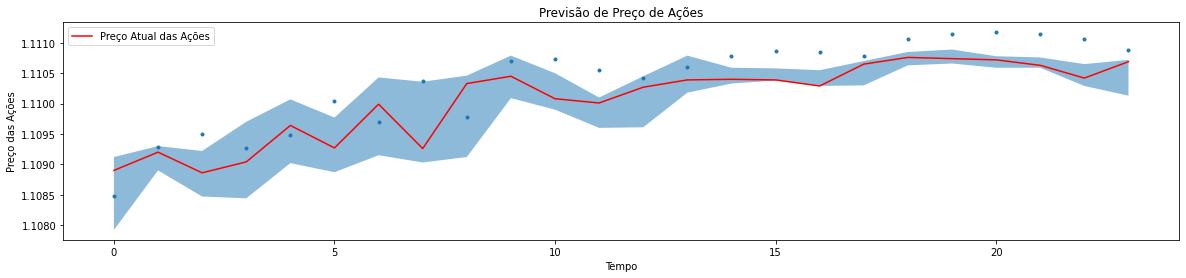

Acertos:  13
Erros:  11
Pontos Ganhos:  220
% 54.166666666666664
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108474                 49
1    1.10890  1.10930  1.10890      1.10920  1.109281                 87
2    1.10920  1.10922  1.10847      1.10886  1.109500                 53
3    1.10886  1.10970  1.10844      1.10904  1.109275                 94
4    1.10904  1.11007  1.10902      1.10964  1.109475                138
5    1.10964  1.10977  1.10887      1.10927  1.110035                102
6    1.10927  1.11043  1.10915      1.10999  1.109700                144
7    1.10999  1.11036  1.10903      1.10926  1.110365                 71
8    1.10926  1.11046  1.10912      1.11033  1.109777                122
9    1.11033  1.11079  1.11009      1.11045  1.110695                159
10   1.11045  1.11050  1.10990      1.11008  1.110741                123
11   1.11008  1.11010  1.109

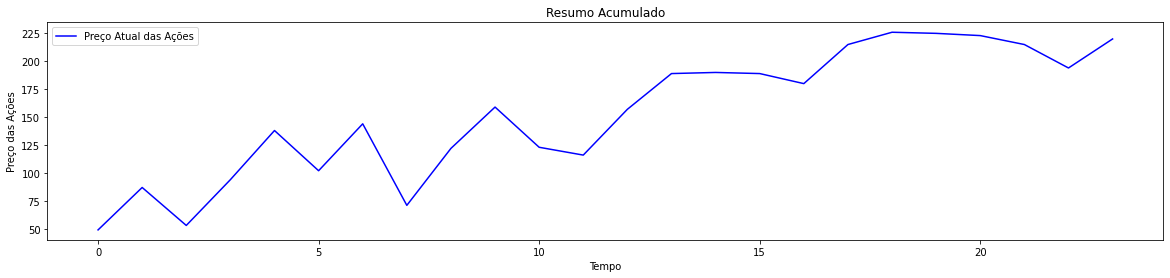

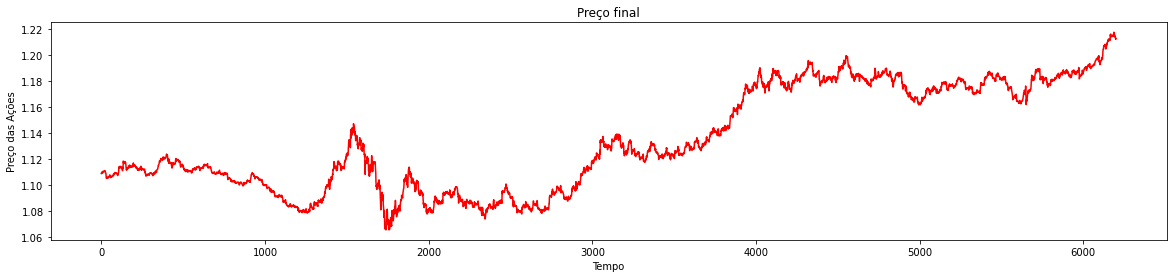

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0141
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 13/30
776/776 [====

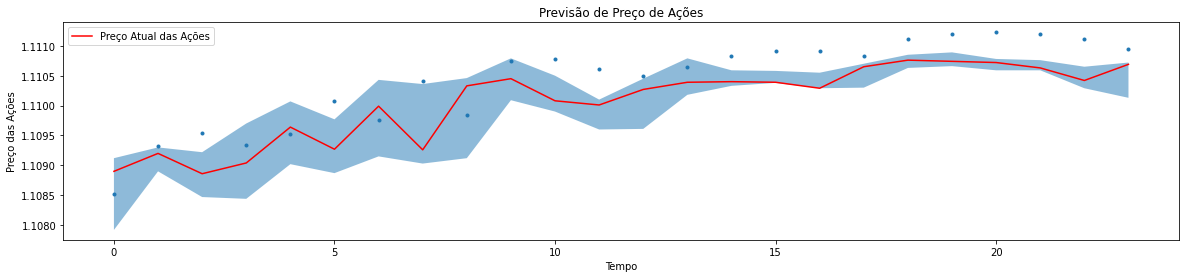

Acertos:  13
Erros:  11
Pontos Ganhos:  234
% 54.166666666666664
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108522                 55
1    1.10890  1.10930  1.10890      1.10920  1.109325                 84
2    1.10920  1.10922  1.10847      1.10886  1.109540                 50
3    1.10886  1.10970  1.10844      1.10904  1.109336                 97
4    1.10904  1.11007  1.10902      1.10964  1.109525                144
5    1.10964  1.10977  1.10887      1.10927  1.110078                108
6    1.10927  1.11043  1.10915      1.10999  1.109762                157
7    1.10999  1.11036  1.10903      1.10926  1.110410                 84
8    1.10926  1.11046  1.10912      1.11033  1.109838                142
9    1.11033  1.11079  1.11009      1.11045  1.110749                183
10   1.11045  1.11050  1.10990      1.11008  1.110786                147
11   1.11008  1.11010  1.109

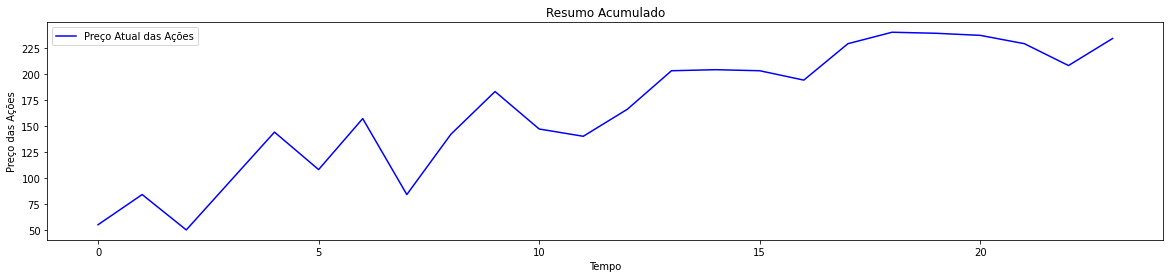

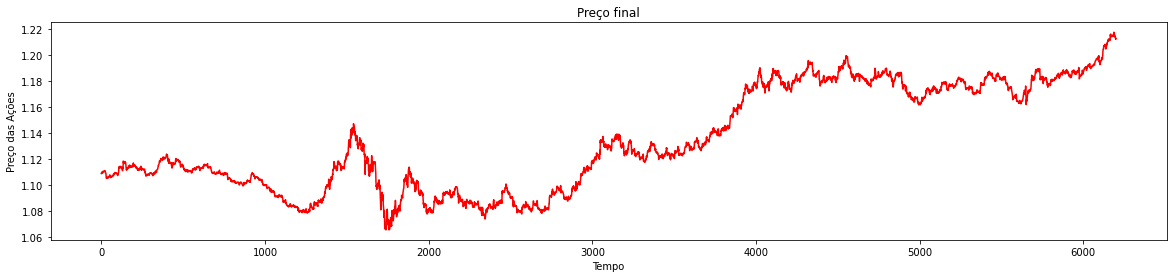

Epoch 1/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0127
Epoch 2/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0055
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0056
Epoch 4/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0050
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 6/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0049
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 8/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0045
Epoch 10/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0046
Epoch 12/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0047
Epoch 13/30
776/776 [====

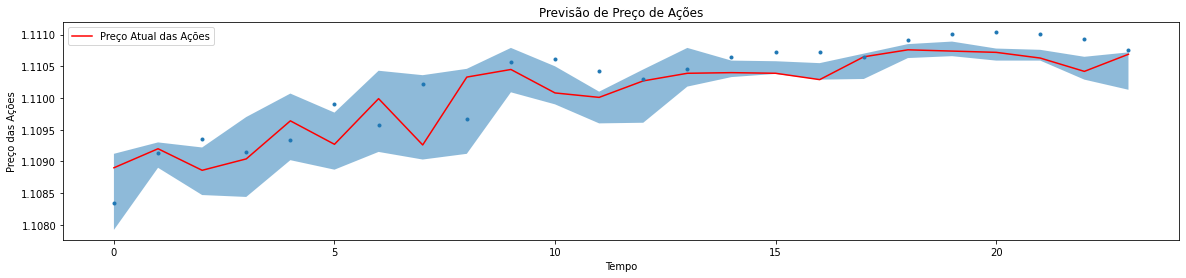

Acertos:  14
Erros:  10
Pontos Ganhos:  201
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108339                 37
1    1.10890  1.10930  1.10890      1.10920  1.109135                 61
2    1.10920  1.10922  1.10847      1.10886  1.109358                 27
3    1.10886  1.10970  1.10844      1.10904  1.109149                 56
4    1.10904  1.11007  1.10902      1.10964  1.109344                 85
5    1.10964  1.10977  1.10887      1.10927  1.109898                 49
6    1.10927  1.11043  1.10915      1.10999  1.109582                 80
7    1.10999  1.11036  1.10903      1.10926  1.110226                103
8    1.10926  1.11046  1.10912      1.11033  1.109668                144
9    1.11033  1.11079  1.11009      1.11045  1.110562                167
10   1.11045  1.11050  1.10990      1.11008  1.110608                131
11   1.11008  1.11010  1.109

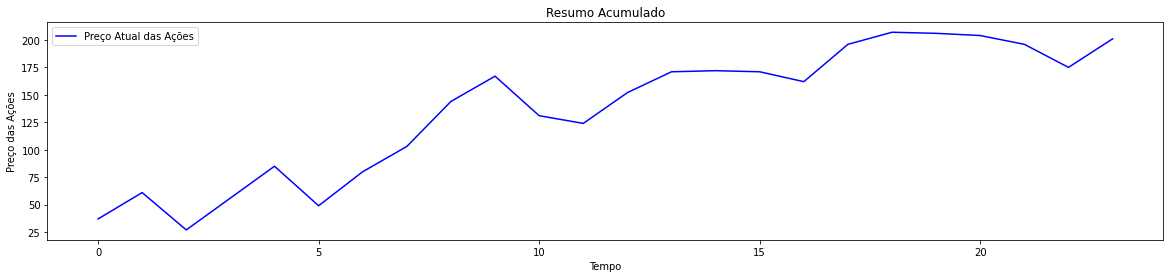

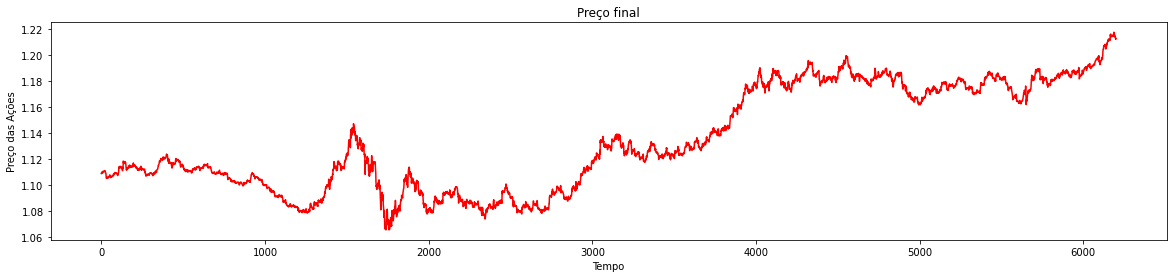

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0129
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 5/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 13/30
776/776 [====

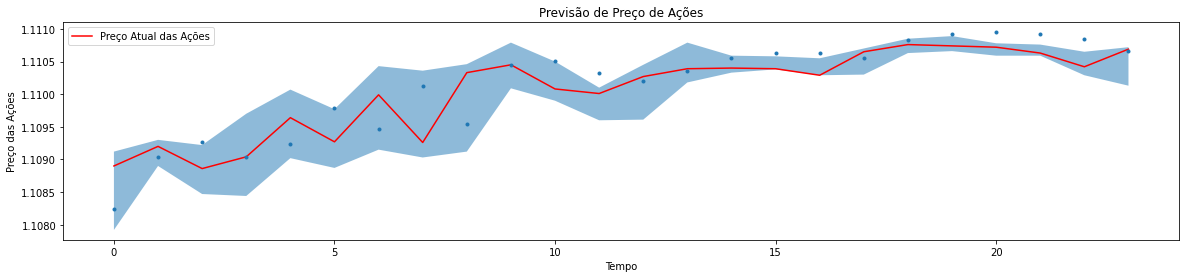

Acertos:  14
Erros:  10
Pontos Ganhos:  105
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108236                 27
1    1.10890  1.10930  1.10890      1.10920  1.109030                 40
2    1.10920  1.10922  1.10847      1.10886  1.109262                  6
3    1.10886  1.10970  1.10844      1.10904  1.109043                 24
4    1.10904  1.11007  1.10902      1.10964  1.109232                 43
5    1.10964  1.10977  1.10887      1.10927  1.109792                  7
6    1.10927  1.11043  1.10915      1.10999  1.109469                 27
7    1.10999  1.11036  1.10903      1.10926  1.110120                 40
8    1.10926  1.11046  1.10912      1.11033  1.109544                 68
9    1.11033  1.11079  1.11009      1.11045  1.110452                 80
10   1.11045  1.11050  1.10990      1.11008  1.110507                 44
11   1.11008  1.11010  1.109

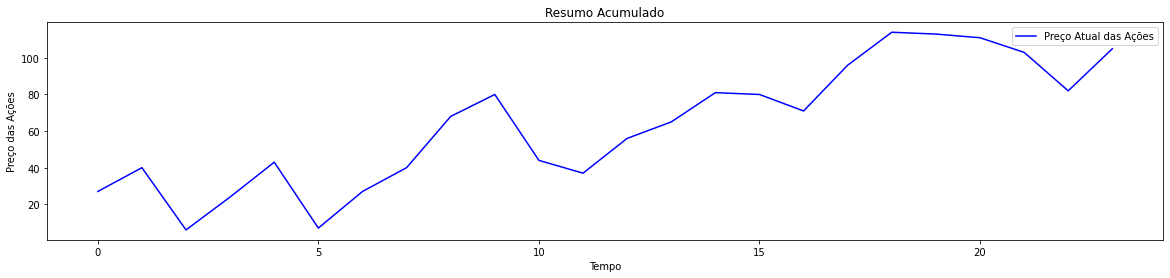

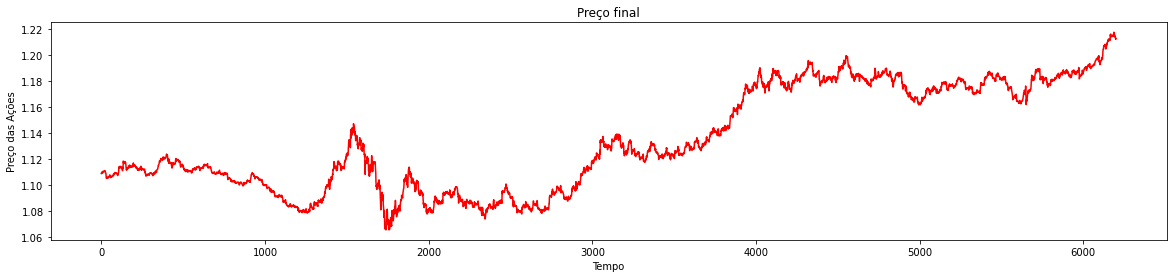

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0133
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

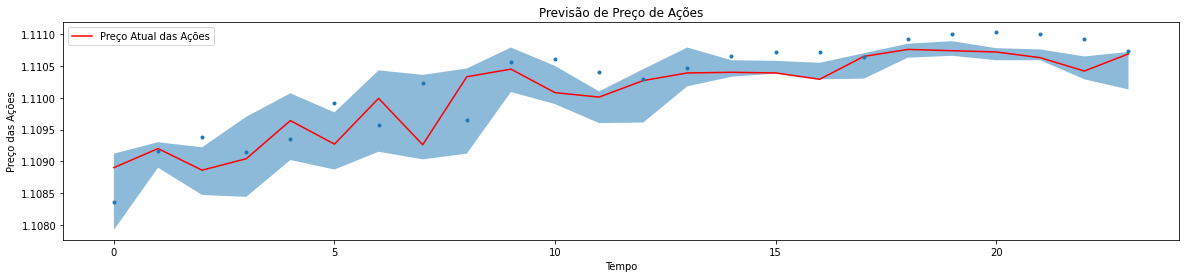

Acertos:  14
Erros:  10
Pontos Ganhos:  203
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108356                 39
1    1.10890  1.10930  1.10890      1.10920  1.109156                 64
2    1.10920  1.10922  1.10847      1.10886  1.109380                 30
3    1.10886  1.10970  1.10844      1.10904  1.109146                 59
4    1.10904  1.11007  1.10902      1.10964  1.109353                 89
5    1.10964  1.10977  1.10887      1.10927  1.109911                 53
6    1.10927  1.11043  1.10915      1.10999  1.109571                 83
7    1.10999  1.11036  1.10903      1.10926  1.110236                107
8    1.10926  1.11046  1.10912      1.11033  1.109654                146
9    1.11033  1.11079  1.11009      1.11045  1.110559                169
10   1.11045  1.11050  1.10990      1.11008  1.110614                133
11   1.11008  1.11010  1.109

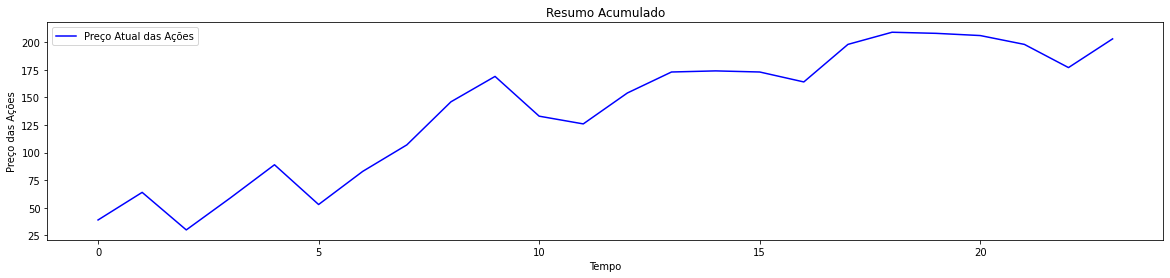

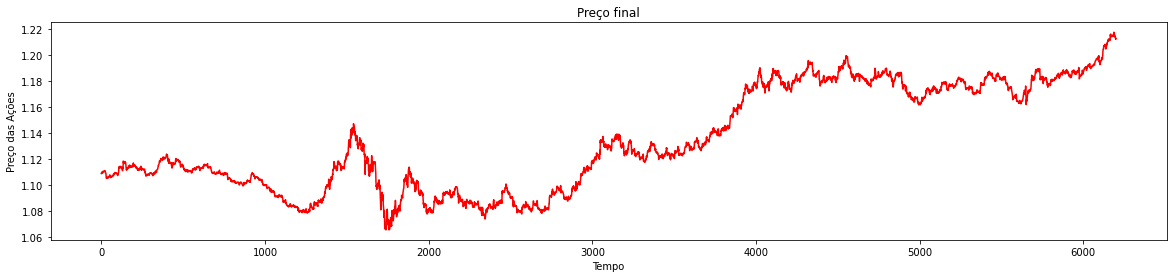

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0131
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0054
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 10/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0049
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

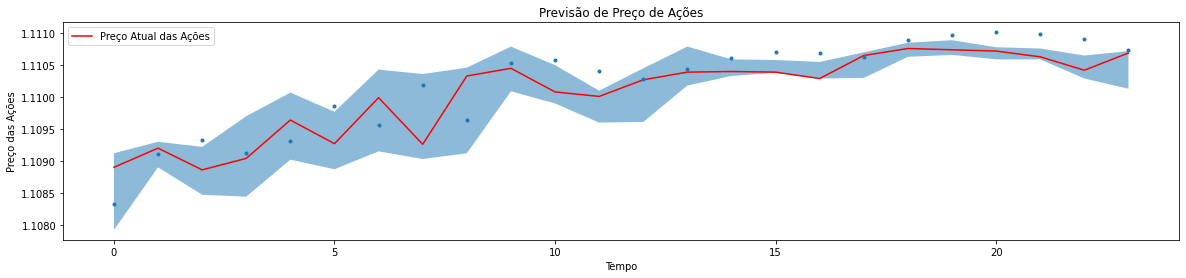

Acertos:  14
Erros:  10
Pontos Ganhos:  175
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108318                 34
1    1.10890  1.10930  1.10890      1.10920  1.109106                 55
2    1.10920  1.10922  1.10847      1.10886  1.109324                 21
3    1.10886  1.10970  1.10844      1.10904  1.109127                 48
4    1.10904  1.11007  1.10902      1.10964  1.109317                 76
5    1.10964  1.10977  1.10887      1.10927  1.109865                 40
6    1.10927  1.11043  1.10915      1.10999  1.109556                 69
7    1.10999  1.11036  1.10903      1.10926  1.110195                 90
8    1.10926  1.11046  1.10912      1.11033  1.109644                128
9    1.11033  1.11079  1.11009      1.11045  1.110527                148
10   1.11045  1.11050  1.10990      1.11008  1.110574                112
11   1.11008  1.11010  1.109

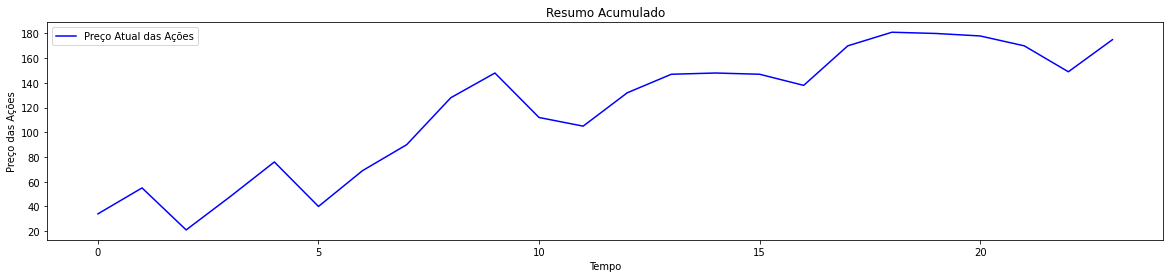

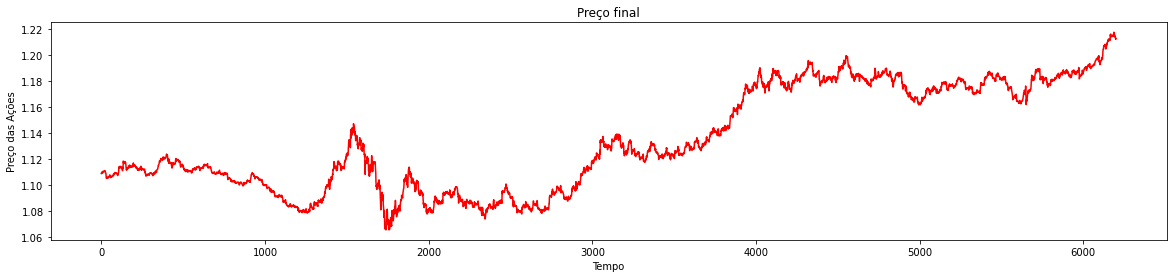

Epoch 1/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0128
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 4/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0052
Epoch 5/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

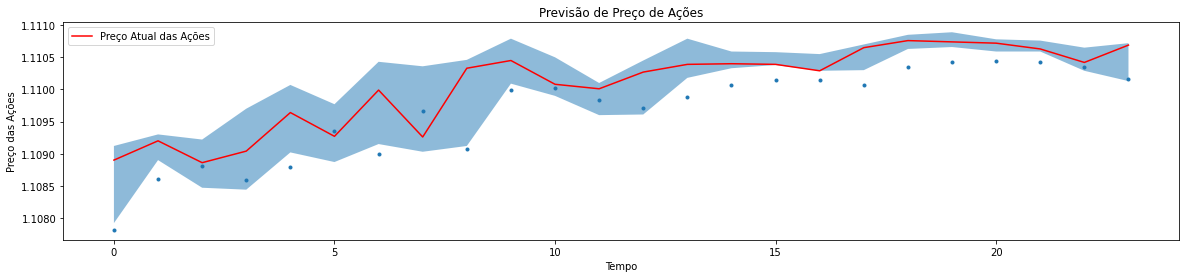

Acertos:  14
Erros:  10
Pontos Ganhos:  -133
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107814                -93
1    1.10890  1.10930  1.10890      1.10920  1.108610               -122
2    1.10920  1.10922  1.10847      1.10886  1.108814                -83
3    1.10886  1.10970  1.10844      1.10904  1.108586                -56
4    1.10904  1.11007  1.10902      1.10964  1.108794               -115
5    1.10964  1.10977  1.10887      1.10927  1.109346                -86
6    1.10927  1.11043  1.10915      1.10999  1.109001               -158
7    1.10999  1.11036  1.10903      1.10926  1.109668               -127
8    1.10926  1.11046  1.10912      1.11033  1.109078               -234
9    1.11033  1.11079  1.11009      1.11045  1.109991               -245
10   1.11045  1.11050  1.10990      1.11008  1.110024               -203
11   1.11008  1.11010  1.10

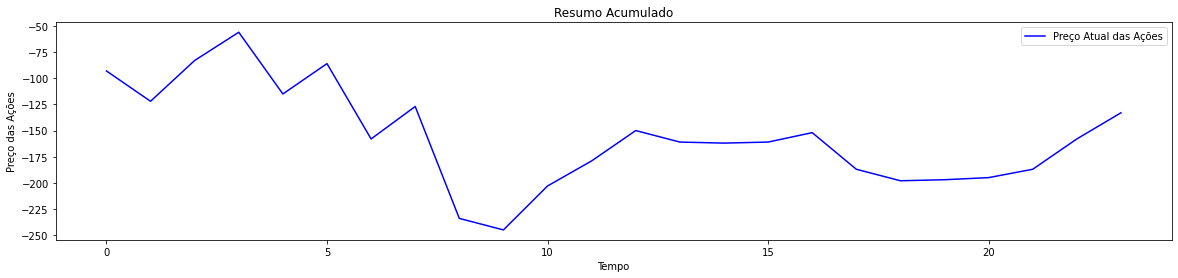

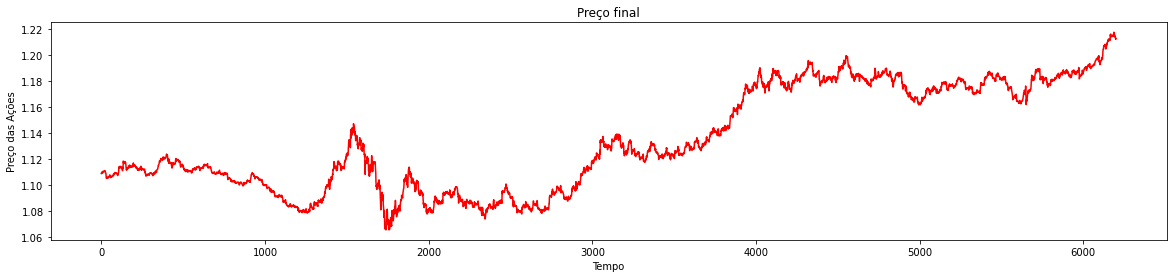

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0126
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

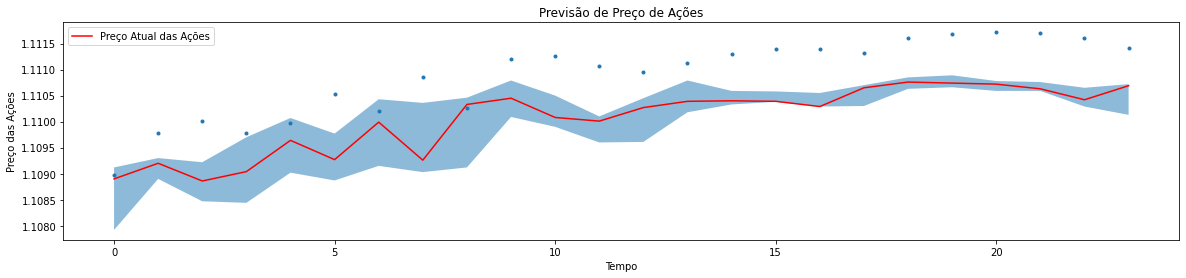

Acertos:  13
Erros:  11
Pontos Ganhos:  325
% 54.166666666666664
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108976                100
1    1.10890  1.10930  1.10890      1.10920  1.109775                129
2    1.10920  1.10922  1.10847      1.10886  1.110007                 95
3    1.10886  1.10970  1.10844      1.10904  1.109786                113
4    1.10904  1.11007  1.10902      1.10964  1.109967                205
5    1.10964  1.10977  1.10887      1.10927  1.110531                169
6    1.10927  1.11043  1.10915      1.10999  1.110203                262
7    1.10999  1.11036  1.10903      1.10926  1.110864                189
8    1.10926  1.11046  1.10912      1.11033  1.110263                289
9    1.11033  1.11079  1.11009      1.11045  1.111196                300
10   1.11045  1.11050  1.10990      1.11008  1.111253                264
11   1.11008  1.11010  1.109

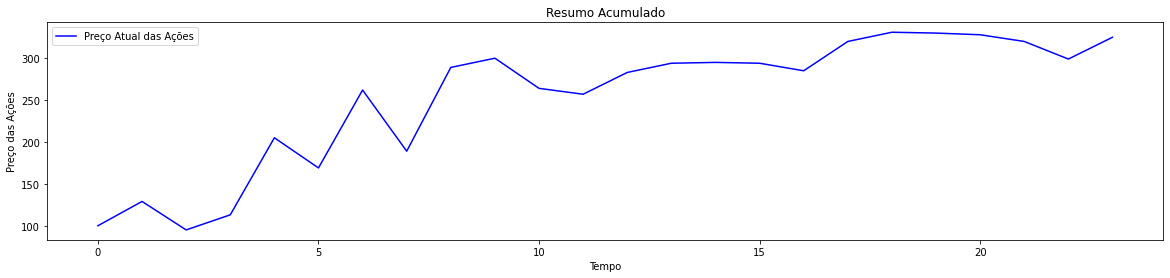

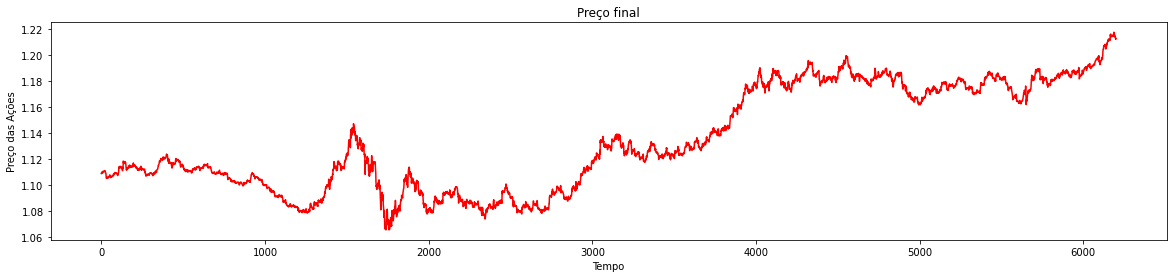

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0128
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 12/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

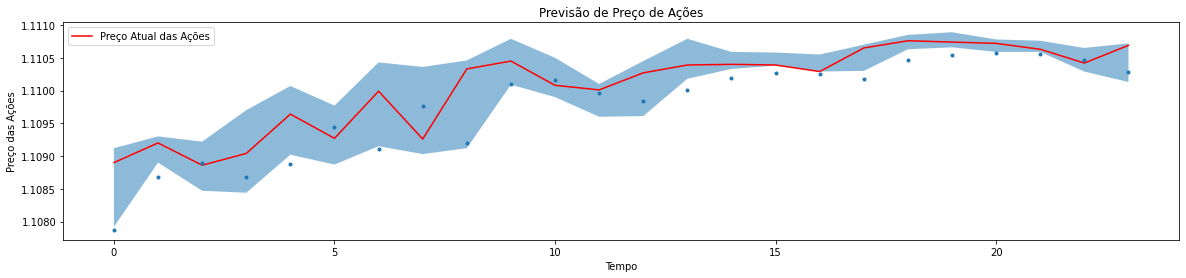

Acertos:  16
Erros:  8
Pontos Ganhos:  -87
% 66.66666666666667
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107872                -93
1    1.10890  1.10930  1.10890      1.10920  1.108675               -122
2    1.10920  1.10922  1.10847      1.10886  1.108901                -92
3    1.10886  1.10970  1.10844      1.10904  1.108683                -74
4    1.10904  1.11007  1.10902      1.10964  1.108881               -133
5    1.10964  1.10977  1.10887      1.10927  1.109437               -113
6    1.10927  1.11043  1.10915      1.10999  1.109112               -185
7    1.10999  1.11036  1.10903      1.10926  1.109769               -164
8    1.10926  1.11046  1.10912      1.11033  1.109196               -159
9    1.11033  1.11079  1.11009      1.11045  1.110096               -137
10   1.11045  1.11050  1.10990      1.11008  1.110154               -107
11   1.11008  1.11010  1.10960

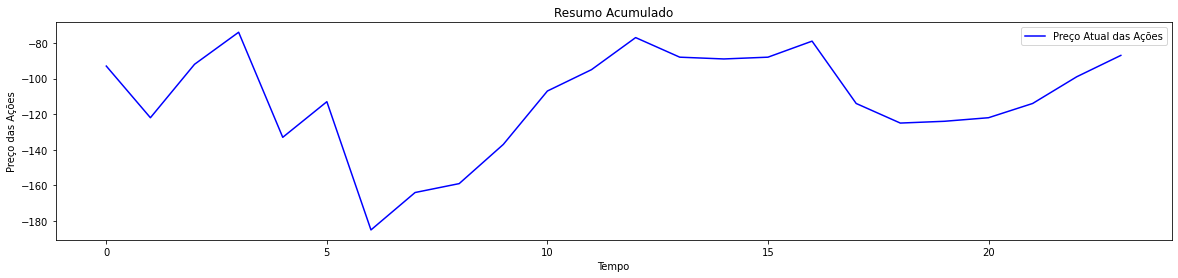

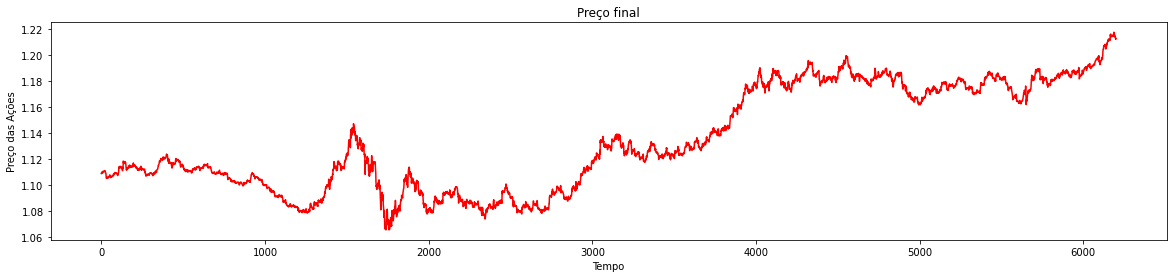

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0150
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0057
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 9/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0050
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 11/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0048
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0044
Epoch 13/30
776/776 [====

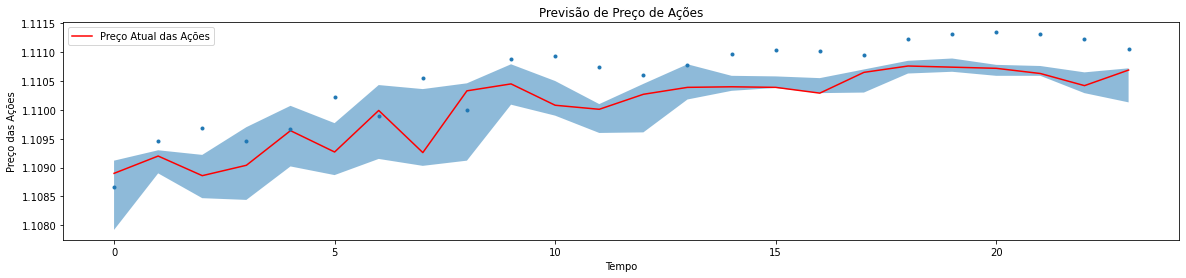

Acertos:  13
Erros:  11
Pontos Ganhos:  288
% 54.166666666666664
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108663                 68
1    1.10890  1.10930  1.10890      1.10920  1.109462                 97
2    1.10920  1.10922  1.10847      1.10886  1.109681                 63
3    1.10886  1.10970  1.10844      1.10904  1.109467                123
4    1.10904  1.11007  1.10902      1.10964  1.109671                186
5    1.10964  1.10977  1.10887      1.10927  1.110223                150
6    1.10927  1.11043  1.10915      1.10999  1.109898                213
7    1.10999  1.11036  1.10903      1.10926  1.110552                140
8    1.10926  1.11046  1.10912      1.11033  1.109990                213
9    1.11033  1.11079  1.11009      1.11045  1.110880                224
10   1.11045  1.11050  1.10990      1.11008  1.110928                188
11   1.11008  1.11010  1.109

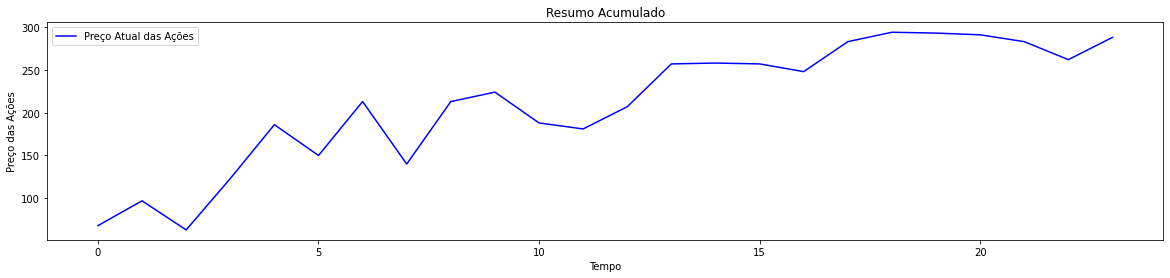

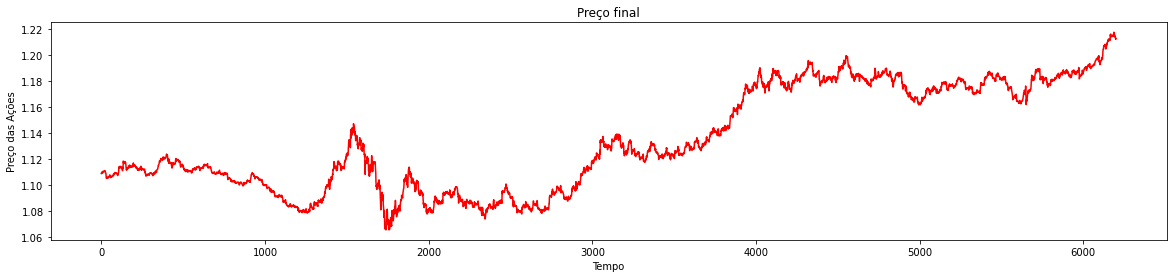

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0133
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0057
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0056
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

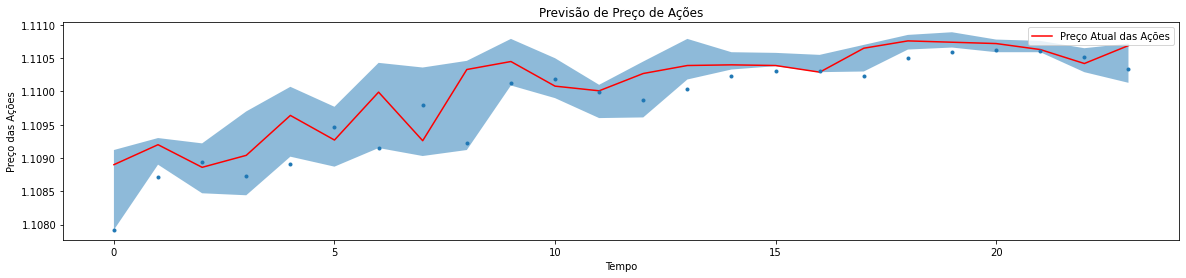

Acertos:  16
Erros:  8
Pontos Ganhos:  -120
% 66.66666666666667
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107919                -93
1    1.10890  1.10930  1.10890      1.10920  1.108712               -122
2    1.10920  1.10922  1.10847      1.10886  1.108947                -98
3    1.10886  1.10970  1.10844      1.10904  1.108726                -85
4    1.10904  1.11007  1.10902      1.10964  1.108912               -144
5    1.10964  1.10977  1.10887      1.10927  1.109470               -128
6    1.10927  1.11043  1.10915      1.10999  1.109148               -200
7    1.10999  1.11036  1.10903      1.10926  1.109799               -181
8    1.10926  1.11046  1.10912      1.11033  1.109220               -178
9    1.11033  1.11079  1.11009      1.11045  1.110125               -158
10   1.11045  1.11050  1.10990      1.11008  1.110190               -133
11   1.11008  1.11010  1.1096

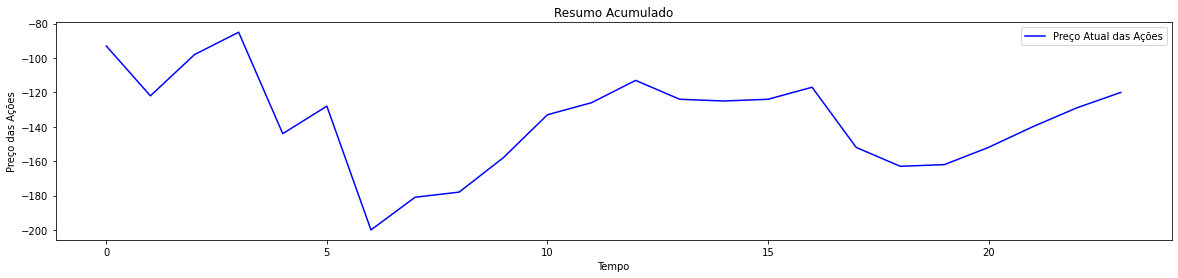

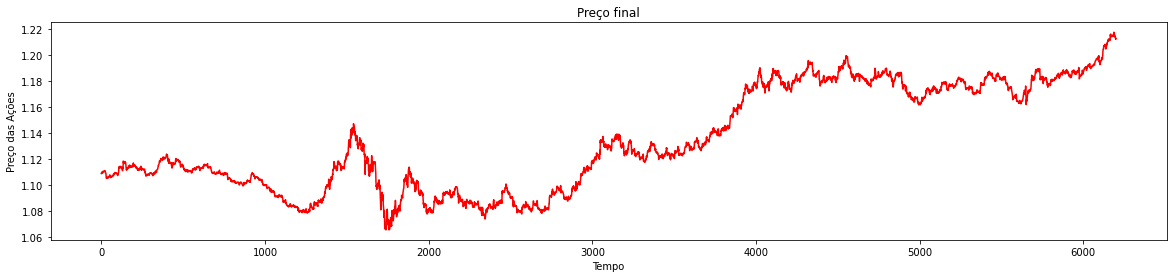

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0128
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0057
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

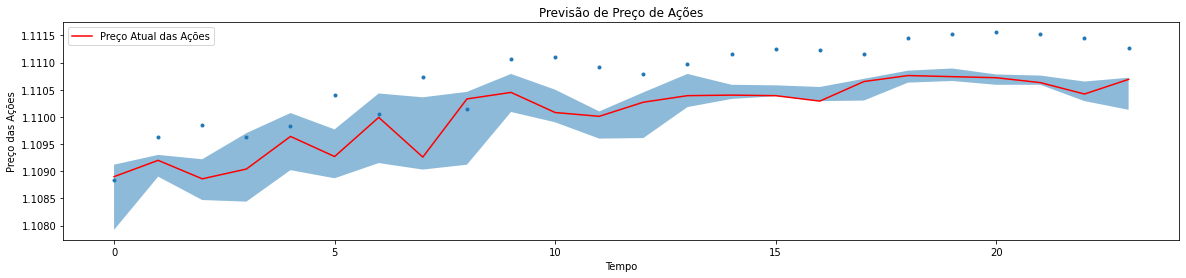

Acertos:  13
Erros:  11
Pontos Ganhos:  327
% 54.166666666666664
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108830                 85
1    1.10890  1.10930  1.10890      1.10920  1.109635                114
2    1.10920  1.10922  1.10847      1.10886  1.109855                 80
3    1.10886  1.10970  1.10844      1.10904  1.109632                156
4    1.10904  1.11007  1.10902      1.10964  1.109833                234
5    1.10964  1.10977  1.10887      1.10927  1.110398                198
6    1.10927  1.11043  1.10915      1.10999  1.110058                276
7    1.10999  1.11036  1.10903      1.10926  1.110730                203
8    1.10926  1.11046  1.10912      1.11033  1.110138                291
9    1.11033  1.11079  1.11009      1.11045  1.111058                302
10   1.11045  1.11050  1.10990      1.11008  1.111108                266
11   1.11008  1.11010  1.109

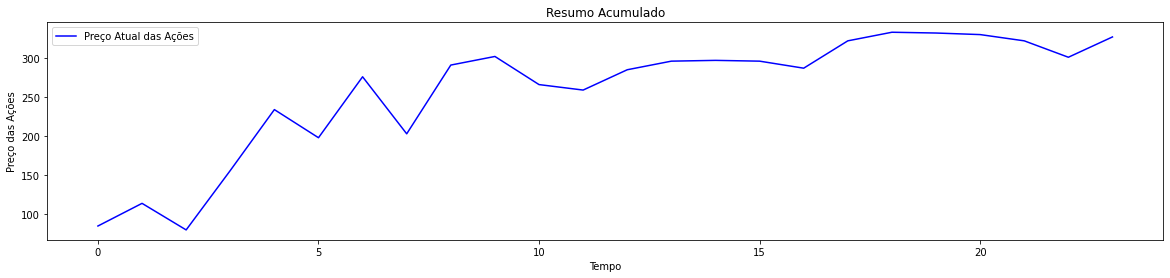

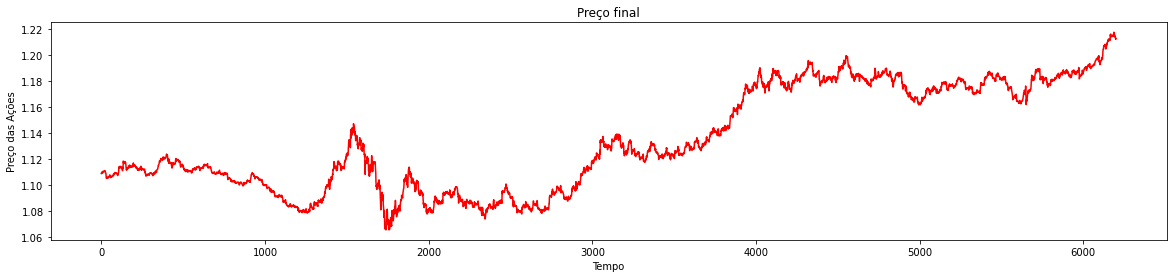

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0140
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 4/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0053
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

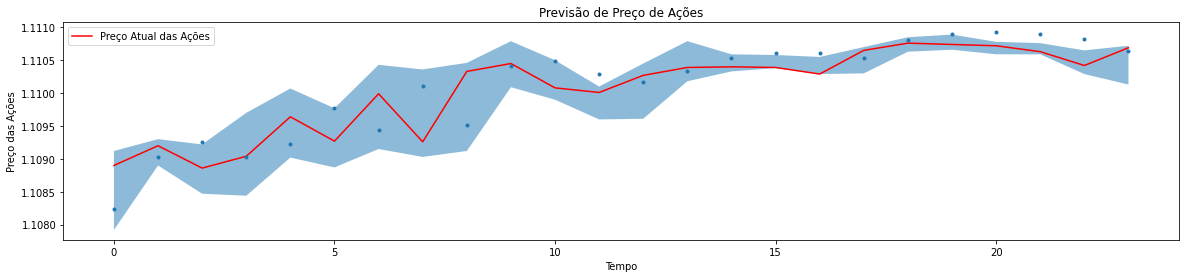

Acertos:  15
Erros:  9
Pontos Ganhos:  116
% 62.5
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108244                 27
1    1.10890  1.10930  1.10890      1.10920  1.109030                 40
2    1.10920  1.10922  1.10847      1.10886  1.109254                  6
3    1.10886  1.10970  1.10844      1.10904  1.109035                 22
4    1.10904  1.11007  1.10902      1.10964  1.109225                 41
5    1.10964  1.10977  1.10887      1.10927  1.109775                  5
6    1.10927  1.11043  1.10915      1.10999  1.109447                 23
7    1.10999  1.11036  1.10903      1.10926  1.110104                 34
8    1.10926  1.11046  1.10912      1.11033  1.109520                 59
9    1.11033  1.11079  1.11009      1.11045  1.110420                 68
10   1.11045  1.11050  1.10990      1.11008  1.110483                 70
11   1.11008  1.11010  1.10960      1.11001

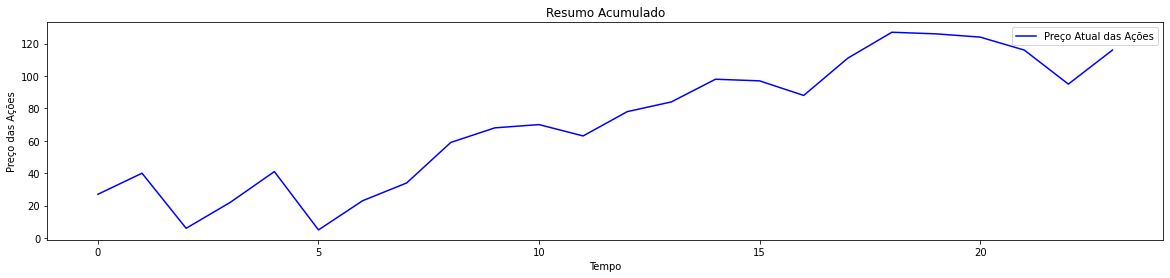

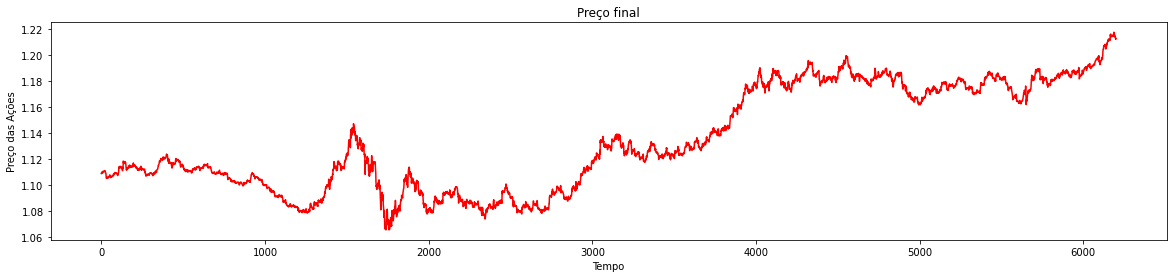

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0129
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 3/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0053
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 6/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 10/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0048
Epoch 11/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

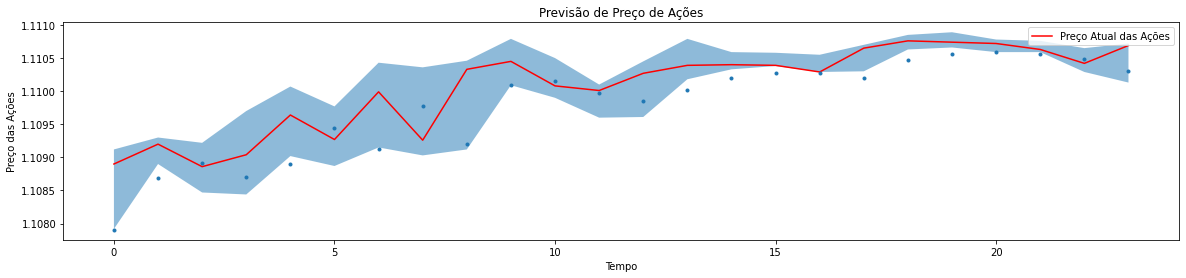

Acertos:  16
Erros:  8
Pontos Ganhos:  -85
% 66.66666666666667
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107905                -93
1    1.10890  1.10930  1.10890      1.10920  1.108691               -122
2    1.10920  1.10922  1.10847      1.10886  1.108914                -93
3    1.10886  1.10970  1.10844      1.10904  1.108706                -79
4    1.10904  1.11007  1.10902      1.10964  1.108895               -138
5    1.10964  1.10977  1.10887      1.10927  1.109443               -118
6    1.10927  1.11043  1.10915      1.10999  1.109125               -190
7    1.10999  1.11036  1.10903      1.10926  1.109774               -169
8    1.10926  1.11046  1.10912      1.11033  1.109205               -165
9    1.11033  1.11079  1.11009      1.11045  1.110094               -142
10   1.11045  1.11050  1.10990      1.11008  1.110155               -112
11   1.11008  1.11010  1.10960

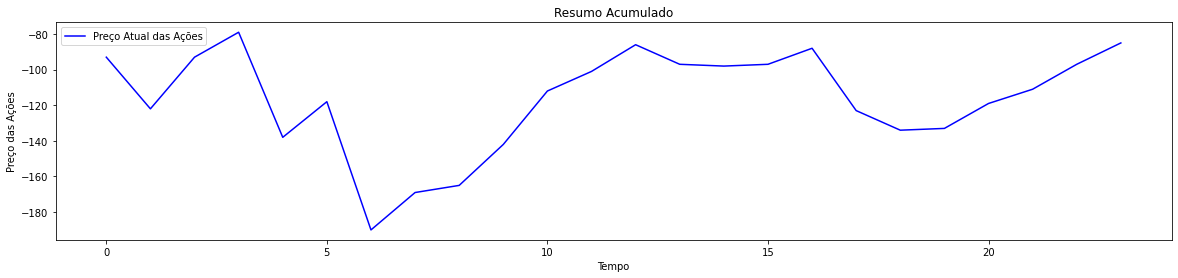

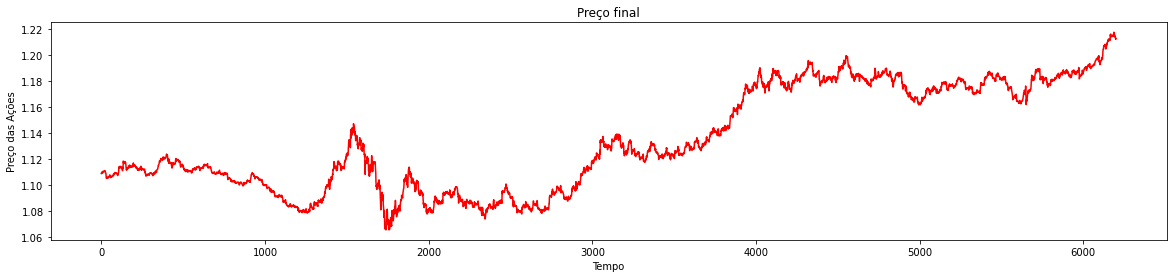

Epoch 1/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0130
Epoch 2/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0053
Epoch 3/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0051
Epoch 4/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 6/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 7/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 8/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 9/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 13/30
776/776 [====

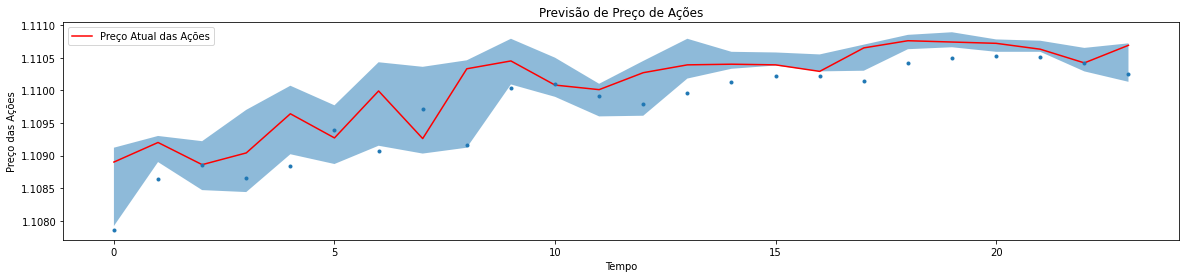

Acertos:  15
Erros:  9
Pontos Ganhos:  -76
% 62.5
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107860                -93
1    1.10890  1.10930  1.10890      1.10920  1.108633               -122
2    1.10920  1.10922  1.10847      1.10886  1.108862                -89
3    1.10886  1.10970  1.10844      1.10904  1.108658                -69
4    1.10904  1.11007  1.10902      1.10964  1.108839               -128
5    1.10964  1.10977  1.10887      1.10927  1.109384               -103
6    1.10927  1.11043  1.10915      1.10999  1.109077               -175
7    1.10999  1.11036  1.10903      1.10926  1.109709               -147
8    1.10926  1.11046  1.10912      1.11033  1.109154               -137
9    1.11033  1.11079  1.11009      1.11045  1.110032               -148
10   1.11045  1.11050  1.10990      1.11008  1.110093               -112
11   1.11008  1.11010  1.10960      1.11001

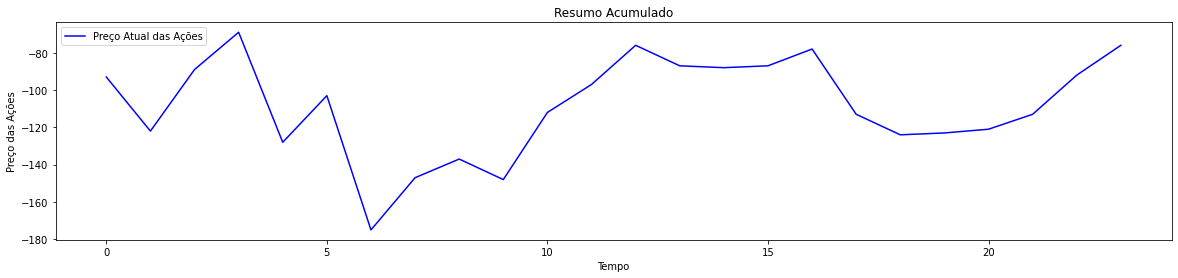

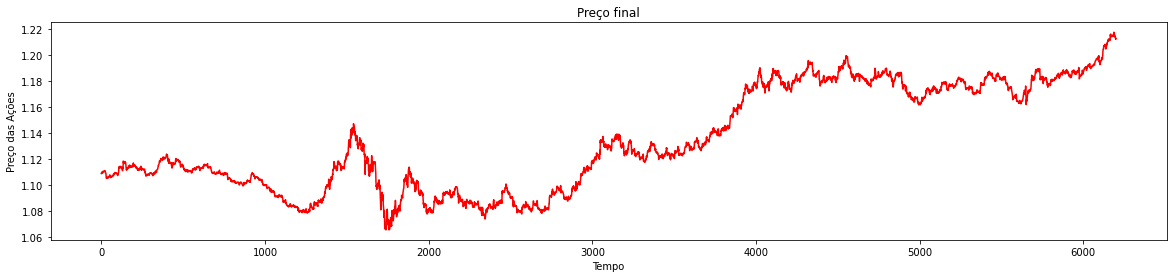

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0139
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 8/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 5s 6ms/step - loss: 0.0050
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

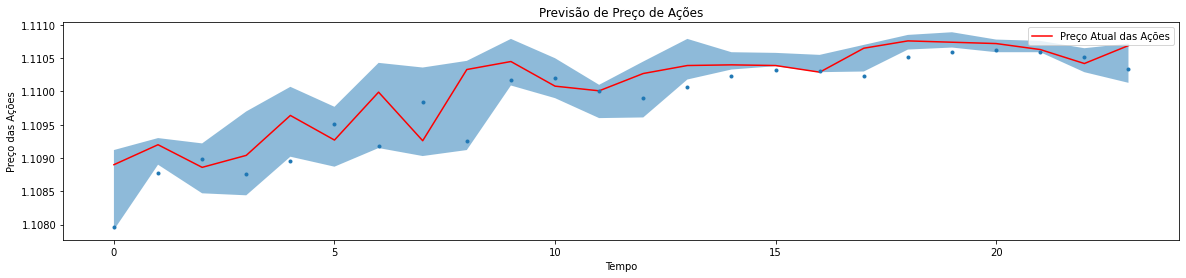

Acertos:  18
Erros:  6
Pontos Ganhos:  32
% 75.0
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.107968                  0
1    1.10890  1.10930  1.10890      1.10920  1.108773                -29
2    1.10920  1.10922  1.10847      1.10886  1.108985                 -7
3    1.10886  1.10970  1.10844      1.10904  1.108760                  3
4    1.10904  1.11007  1.10902      1.10964  1.108958                -56
5    1.10964  1.10977  1.10887      1.10927  1.109515                -43
6    1.10927  1.11043  1.10915      1.10999  1.109182                -34
7    1.10999  1.11036  1.10903      1.10926  1.109837                -20
8    1.10926  1.11046  1.10912      1.11033  1.109252                -19
9    1.11033  1.11079  1.11009      1.11045  1.110175                 -4
10   1.11045  1.11050  1.10990      1.11008  1.110203                 20
11   1.11008  1.11010  1.10960      1.11001 

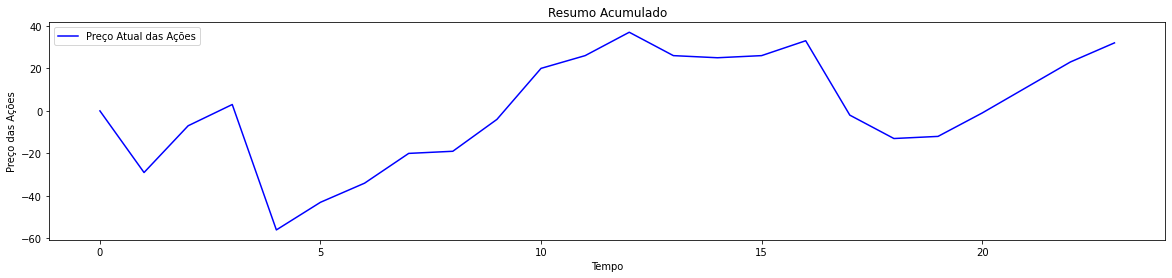

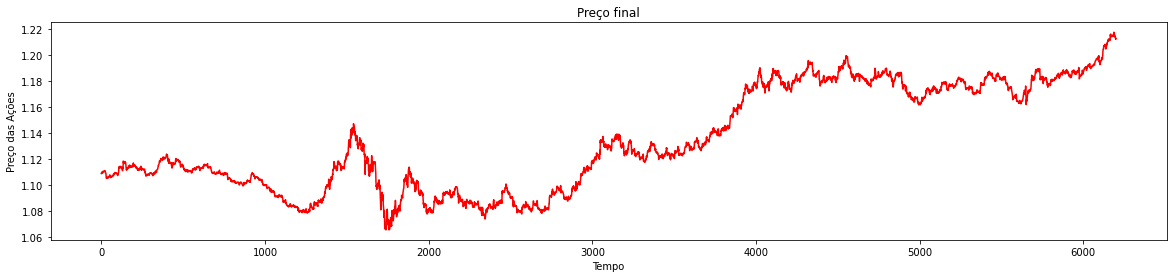

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0131
Epoch 2/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 3/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0057
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0051
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0049
Epoch 10/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0049
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

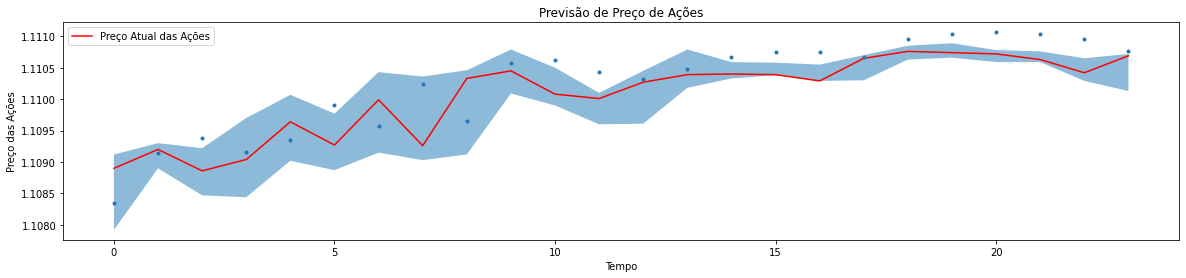

Acertos:  14
Erros:  10
Pontos Ganhos:  208
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108351                 38
1    1.10890  1.10930  1.10890      1.10920  1.109150                 63
2    1.10920  1.10922  1.10847      1.10886  1.109378                 29
3    1.10886  1.10970  1.10844      1.10904  1.109154                 58
4    1.10904  1.11007  1.10902      1.10964  1.109347                 88
5    1.10964  1.10977  1.10887      1.10927  1.109910                 52
6    1.10927  1.11043  1.10915      1.10999  1.109578                 83
7    1.10999  1.11036  1.10903      1.10926  1.110239                107
8    1.10926  1.11046  1.10912      1.11033  1.109653                146
9    1.11033  1.11079  1.11009      1.11045  1.110569                169
10   1.11045  1.11050  1.10990      1.11008  1.110622                133
11   1.11008  1.11010  1.109

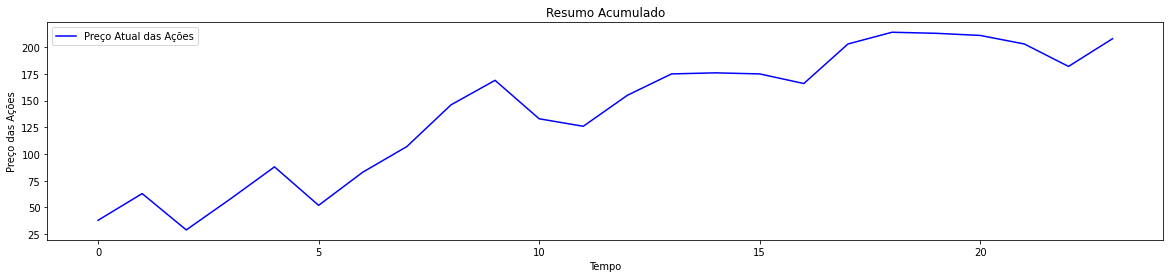

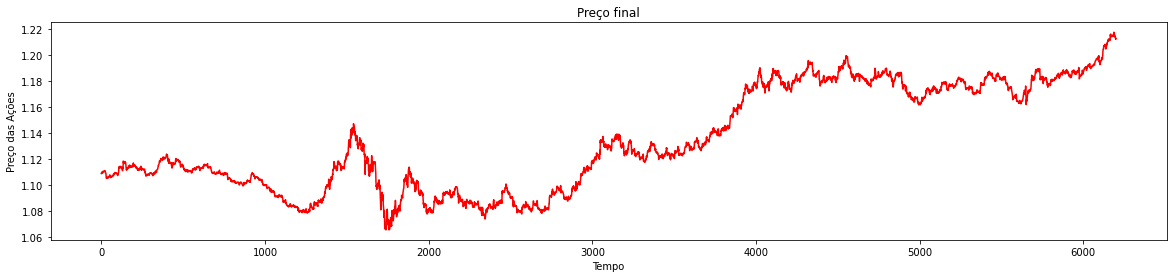

Epoch 1/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0133
Epoch 2/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0054
Epoch 3/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 4/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 5/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 6/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 7/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0050
Epoch 8/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0052
Epoch 9/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 10/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 11/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 12/30
776/776 [==============================] - 4s 6ms/step - loss: 0.0048
Epoch 13/30
776/776 [====

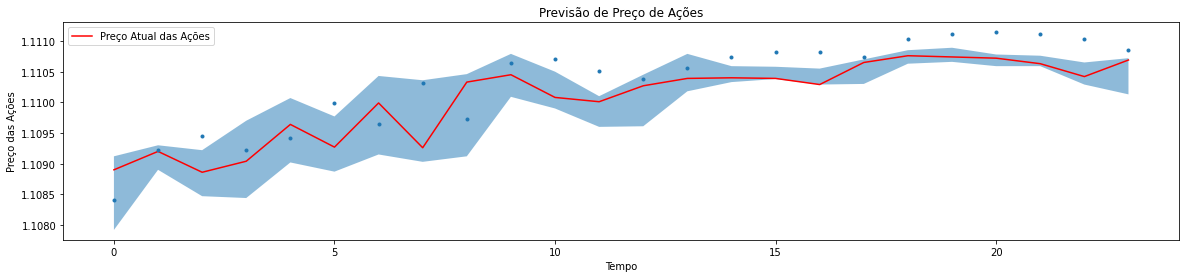

Acertos:  14
Erros:  10
Pontos Ganhos:  282
% 58.333333333333336
Meses em teste estudados:  258
    Abertura   Máxima   Mínima  Fecahmaneto  Previsão  Resumo Acumulado 
0    1.10797  1.10912  1.10792      1.10890  1.108415                 44
1    1.10890  1.10930  1.10890      1.10920  1.109221                 76
2    1.10920  1.10922  1.10847      1.10886  1.109446                 42
3    1.10886  1.10970  1.10844      1.10904  1.109226                 79
4    1.10904  1.11007  1.10902      1.10964  1.109422                116
5    1.10964  1.10977  1.10887      1.10927  1.109983                 80
6    1.10927  1.11043  1.10915      1.10999  1.109652                118
7    1.10999  1.11036  1.10903      1.10926  1.110318                150
8    1.10926  1.11046  1.10912      1.11033  1.109730                197
9    1.11033  1.11079  1.11009      1.11045  1.110646                228
10   1.11045  1.11050  1.10990      1.11008  1.110702                192
11   1.11008  1.11010  1.109

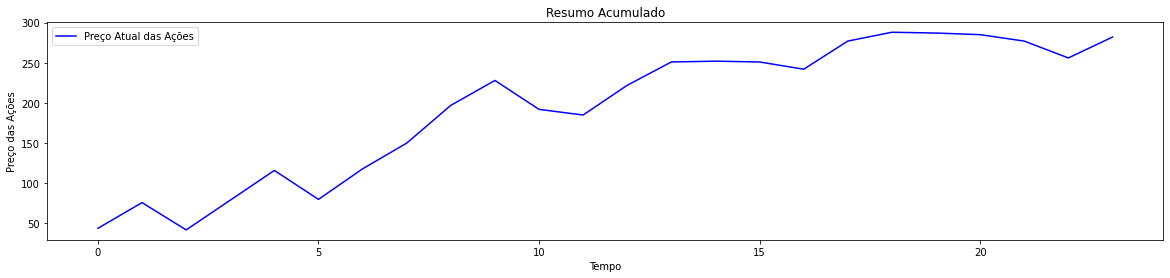

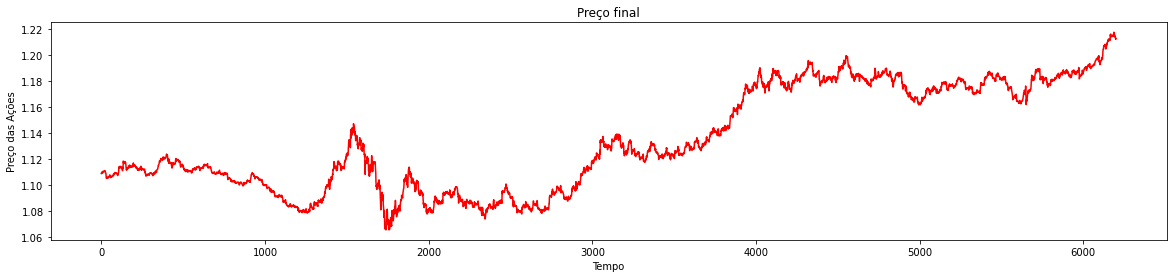

101 83.33333333333333


In [ ]:
maior_ponto   =  0
rotacao       =  0
maior_acerto      =  0

#for epochs in range(30,50):
for i in range(20):
   model = treinamento_rede_neural(timestamp, features, x_train, y_train, epochs)
   pontos,acerto = teste_rede(model ,df_test, df_test_orig, sc, janela )
   if acerto > maior_acerto:
     if pontos > maior_ponto:
       model.save('drive/My Drive/TCC/modelo/LSTM')
       maior_ponto = pontos
       maior_acerto = acerto

print(maior_ponto, maior_acerto)

In [ ]:
# previsao = pd.DataFrame(data=predicted_price , columns=['Previsão'])
# numero_real = pd.DataFrame(data=y_test , columns=['Fecahmaneto'])
# #y_max_pd = pd.DataFrame(data=y_max, columns=['Máxima'])
# preco_de_abertura = pd.DataFrame(data=open_test , columns=['Abertura'])
# maxima = pd.DataFrame(data=y_max , columns=['Máxima'])
# minima = pd.DataFrame(data=y_min , columns=['Mínima'])

In [ ]:
# frames = [ preco_de_abertura, maxima, minima, numero_real, previsao,resumo_acumulado]
# result = pd.concat(frames, axis=1, join='inner')
# print(result)

In [ ]:
# plt.plot(resumo_acumulado, color='blue', label='Preço Atual das Ações')
# plt.title('Resumo Acumulado')
# plt.xlabel('Tempo')
# plt.ylabel('Preço das Ações')
# plt.legend()
# plt.show()
# plt.title('Preço final')
# plt.xlabel('Tempo')
# plt.ylabel('Preço das Ações')
# plt.plot(y_test, color='red', label='Preço Atual das Ações')
